In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from detectdd.auth_bigquery import BigQueryClient
from detectdd.serializer import Serializer

serializer = Serializer()
cohort_before_icd_filter = serializer.read_total_drug_interactions()
print(len(cohort_before_icd_filter))
cohort_before_icd_filter.head(100)

Loaded cohort from ..\out\total-drug-interactions.out
202718


,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count
0,16796985,27317580,33550086,225798,225893,2160-04-14 12:06:00,16
1,16796985,27317580,33550086,225798,225893,2160-04-13 11:53:00,16
2,17007441,20790097,31504988,225798,225893,2138-06-12 08:25:00,28
3,17007441,20790097,31504988,225798,225893,2138-06-10 00:00:00,28
4,17007441,20790097,31504988,225798,225893,2138-06-10 08:00:00,28
...,...,...,...,...,...,...,...
95,13136352,28816224,32800564,225798,225893,2128-11-09 15:39:00,13
96,13136352,28816224,32800564,225798,225893,2128-11-07 00:33:00,13
97,13136352,28816224,32800564,225798,225893,2128-11-09 00:40:00,13
98,13136352,28816224,32800564,225798,225893,2128-11-09 23:39:00,13


In [2]:
from detectdd.config import icd_data_file
# read ICD code data
icd_codes_raw = pd.read_csv(icd_data_file, encoding='ISO-8859-1')

category_prefixes = ('A', 'B', 'C', 'D')
#category_prefixes = ('A','B', 'C')

def filter_icd_codes(to_filter):
    # The data contains filters with the following meaning.
    #A.1	Induced by medication
    #A.2	Induced by medication or other causes
    #B.1	Poisoning by medication
    #B.2	Poisoning by or harmful use of medication or other causes
    #C	ADE very likely
    #D	ADE likely
    #E	ADE possible
    #U	ADE unlikely
    #V	Induced by vaccine (added)
    
    # simple filter, only accept at A - D
    

    return to_filter.loc[to_filter.iloc[:, 2].str.startswith(category_prefixes, na=False)]
    # TODO - exclude codes where it is unlikely to be drug drug interaction, i.e. T40
    
icd_codes_filtered = filter_icd_codes(icd_codes_raw)
icd_codes_filtered

,Code,Meaning,Consensus Likelihood Rating
0,D52.1,Drug-induced folate deficiency anaemia,A1
1,D59.0,Drug-induced autoimmune haemolytic anaemia,A1
2,D59.2,Drug-induced nonautoimmune haemolytic anaemia,A1
3,D61.1,Drug-induced aplastic anaemia due to chemotherapy,A1
4,D68.3,Hemorrhagic disorder due to circulating antico...,A1
...,...,...,...
347,O74.2,Cardiac complications of anaesthesia during la...,C
348,O74.3,Central nervous system complications of anaest...,C
349,Y63,Failure in dosage during surgical and medical ...,C
350,Y65.1,Wrong fluid in infusion,C


In [3]:
hosp = "physionet-data.mimiciv_hosp"
def get_hadm_id_with_matching_icd_code(icd_codes_filtered=icd_codes_filtered, hadm_ids = [24233473]):
    icd_in_values = ', '.join(["'" + str(x).replace('.','') + "'" for x in icd_codes_filtered['Code'].tolist()])

    likes = []
    codes = icd_codes_filtered['Code']
    
    cleaned_codes = []
    
    for x in codes:
        x = x.replace('.','')
        if len(x) < 5:
            cleaned_codes.append(x + 'X')
    
    cleaned_codes += ["E93", "E94", "E85", "E86"] #ICD 9 therapeutic use and poising prefix, maps to B and A categories
  
    for x in cleaned_codes:
        likes.append(f"d_icd.icd_code LIKE '{x}%'")
    like_clause = "\n OR ".join(likes)
    
    sql = f"""SELECT diag.hadm_id, 
        diag.subject_id, 
          
        COUNT(distinct d_icd.icd_code) AS num_icd_codes,
        
        ARRAY_AGG(d_icd.icd_code) AS icd_code, 
        ARRAY_AGG(DISTINCT d_icd.icd_version) AS icd_versions,
        STRING_AGG(d_icd.long_title) AS icd_titles
        FROM `{hosp}.diagnoses_icd` AS diag
        INNER JOIN `{hosp}.d_icd_diagnoses` AS d_icd
            ON diag.icd_code = d_icd.icd_code
            AND diag.icd_version= d_icd.icd_version
            AND ( d_icd.icd_code IN ({icd_in_values}) OR 
                {like_clause})
        WHERE diag.hadm_id IN ({','.join([str(x) for x in hadm_ids])})
        GROUP BY diag.hadm_id, diag.subject_id
        ORDER BY diag.subject_id"""

    mimic_job = BigQueryClient.auth().query(sql)
    return mimic_job.to_dataframe()

hadm_with_icd_codes = get_hadm_id_with_matching_icd_code(hadm_ids = cohort_before_icd_filter["hadm_id"].drop_duplicates())
print(f"Found {len(hadm_with_icd_codes)} unique codes with icd stays in categories: {category_prefixes}")
hadm_with_icd_codes.head(100)

<google.oauth2.credentials.Credentials object at 0x000001A539F25900> mimic-iv-desktop
Found 2422 unique codes with icd stays in categories: ('A', 'B', 'C')


,hadm_id,subject_id,num_icd_codes,icd_code,icd_versions,icd_titles
0,27411876,10004733,1,[E9383],[9],Intravenous anesthetics causing adverse effect...
1,28477357,10007795,1,[E9319],[9],Other and unspecified anti-infectives causing ...
2,20338077,10007928,1,[E9353],[9],Salicylates causing adverse effects in therape...
3,28157142,10015931,1,[T370X5A],[10],"Adverse effect of sulfonamides, initial encounter"
4,29281842,10016742,2,"[N141, T360X5A]",[10],"Nephropathy induced by other drugs, medicament..."
...,...,...,...,...,...,...
95,28386581,10352268,1,[E861],[10],Hypovolemia
96,24688773,10353094,1,[T380X5A],[10],Adverse effect of glucocorticoids and syntheti...
97,27526421,10361825,1,[E9342],[9],Anticoagulants causing adverse effects in ther...
98,24697158,10369174,2,"[E9348, E9353]",[9],Other agents affecting blood constituents caus...


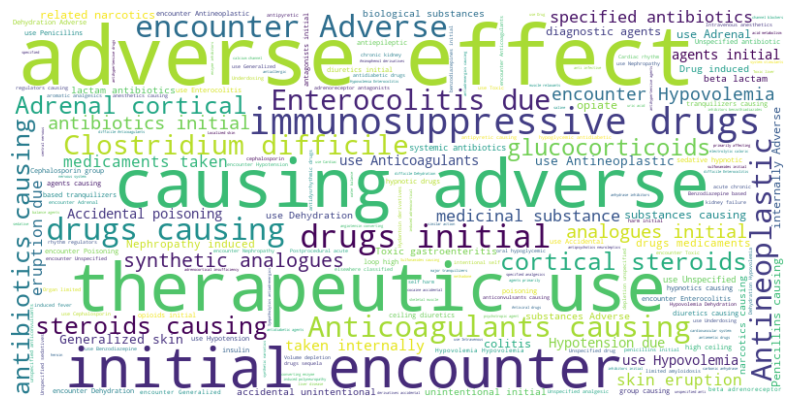

In [4]:
def create_word_cloud_from_column(df, column):
        text = ",".join(df[column])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        # Display the word cloud using matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
        
create_word_cloud_from_column(hadm_with_icd_codes, "icd_titles")

In [5]:
drug_interactions_joined_with_icd = pd.merge(left=cohort_before_icd_filter, right=hadm_with_icd_codes, how='left', on=['hadm_id', 'subject_id'], validate='many_to_one')

print(len(drug_interactions_joined_with_icd))
drug_interactions_joined_with_icd.head(1000)




202718


,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,num_icd_codes,icd_code,icd_versions,icd_titles
0,16796985,27317580,33550086,225798,225893,2160-04-14 12:06:00,16,<NA>,NaN,NaN,NaN
1,16796985,27317580,33550086,225798,225893,2160-04-13 11:53:00,16,<NA>,NaN,NaN,NaN
2,17007441,20790097,31504988,225798,225893,2138-06-12 08:25:00,28,<NA>,NaN,NaN,NaN
3,17007441,20790097,31504988,225798,225893,2138-06-10 00:00:00,28,<NA>,NaN,NaN,NaN
4,17007441,20790097,31504988,225798,225893,2138-06-10 08:00:00,28,<NA>,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
995,15270301,27738686,37568338,225798,225893,2160-02-28 18:30:00,82,<NA>,NaN,NaN,NaN
996,15270301,27738686,37568338,225798,225893,2160-03-06 20:00:00,82,<NA>,NaN,NaN,NaN
997,15270301,27738686,37568338,225798,225893,2160-03-07 08:00:00,82,<NA>,NaN,NaN,NaN
998,15270301,27738686,37568338,225798,225893,2160-02-29 17:15:00,82,<NA>,NaN,NaN,NaN


In [6]:
cohort_without_icd = drug_interactions_joined_with_icd[drug_interactions_joined_with_icd.num_icd_codes.isna()]
cohort_with_icd = drug_interactions_joined_with_icd[~drug_interactions_joined_with_icd.num_icd_codes.isna()]
print(f"Total {len(drug_interactions_joined_with_icd)} drug interactions ")
print(f"Found {len(cohort_with_icd)} drug interactions with icd codes")
print(f"Found {len(cohort_without_icd)} drug interactions without icd codes")

Total 202718 drug interactions 
Found 44632 drug interactions with icd codes
Found 158086 drug interactions without icd codes


In [14]:
## TODO remove truncation, use p95 or p99 instead, this is here to speed up development
print("Truncating cohort to 75th percentile (18)")
counts = cohort_with_icd['stay_id'].value_counts()
print(cohort_with_icd.describe())
print(counts.describe())
truncated_cohort = cohort_with_icd[cohort_with_icd['stay_id'].map(counts) <= 18]
print(truncated_cohort.describe())

counts = cohort_without_icd['stay_id'].value_counts()
truncated_cohort_without_icd = cohort_without_icd[cohort_without_icd['stay_id'].map(counts) <= 18]

serializer.write_cohort(truncated_cohort)

print(len(truncated_cohort_without_icd))
serializer.write_cohort_with_no_icd(truncated_cohort_without_icd)

Truncating cohort to 75th percentile (18)
            subject_id          hadm_id          stay_id  \
count          44632.0          44632.0          44632.0   
mean   14696801.114223  24984367.926667  34890959.382304   
min         10004733.0       20015730.0       30004144.0   
25%         12161387.0       22580355.0       32293675.0   
50%         14539683.0       25070073.0       34878759.0   
75%         17267101.0       27490427.0       37386043.0   
max         19995127.0       29996046.0       39999230.0   
std     2930430.611053   2854809.623007   2960412.659261   

                      dose_b_time  event_count  num_icd_codes  
count                       44632      44632.0        44632.0  
mean   2153-11-01 07:50:07.587381     8.872334        1.36196  
min           2110-02-10 06:30:00          0.0            1.0  
25%           2133-11-18 10:51:45          2.0            1.0  
50%           2153-11-14 01:00:00          5.0            1.0  
75%           2175-07-17 04:34:00

In [8]:
cohort_with_icd.groupby('stay_id').count().describe(percentiles=[ .25, .5, .75, 0.9, 0.95, 0.975, .99])

,subject_id,hadm_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,num_icd_codes,icd_code,icd_versions,icd_titles
count,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000
mean,17.299225,17.299225,17.299225,17.299225,17.299225,17.299225,17.299225,17.299225,17.299225,17.299225
std,27.817531,27.817531,27.817531,27.817531,27.817531,27.817531,27.817531,27.817531,27.817531,27.817531
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
75%,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
90%,40.100000,40.100000,40.100000,40.100000,40.100000,40.100000,40.100000,40.100000,40.100000,40.100000
95%,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
97.5%,88.525000,88.525000,88.525000,88.525000,88.525000,88.525000,88.525000,88.525000,88.525000,88.525000


In [9]:
cohort_without_icd.groupby('stay_id').count().describe(percentiles=[ .25, .5, .75, 0.9, 0.95, 0.975, .99])

,subject_id,hadm_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,num_icd_codes,icd_code,icd_versions,icd_titles
count,8714.000000,8714.000000,8714.000000,8714.000000,8714.000000,8714.000000,8714.0,8714.0,8714.0,8714.0
mean,18.141611,18.141611,18.141611,18.141611,18.141611,18.141611,0.0,0.0,0.0,0.0
std,30.807781,30.807781,30.807781,30.807781,30.807781,30.807781,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0
25%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,0.0,0.0,0.0,0.0
50%,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,0.0,0.0,0.0,0.0
75%,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,0.0,0.0,0.0,0.0
90%,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,0.0,0.0,0.0,0.0
95%,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,0.0,0.0,0.0,0.0
97.5%,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,0.0,0.0,0.0,0.0


In [10]:
print(len(truncated_cohort))
truncated_cohort.groupby('stay_id').count().describe(percentiles=[ .25, .5, .75, 0.9, 0.95, 0.975, .99])

13051


,subject_id,hadm_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,num_icd_codes,icd_code,icd_versions,icd_titles
count,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000
mean,6.843734,6.843734,6.843734,6.843734,6.843734,6.843734,6.843734,6.843734,6.843734,6.843734
std,4.417094,4.417094,4.417094,4.417094,4.417094,4.417094,4.417094,4.417094,4.417094,4.417094
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
75%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
90%,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
95%,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
97.5%,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
